In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from os.path import join
import json
import glob


In [11]:
# import os
# import tensorflow_datasets as tfds
# from PIL import Image
# print(tf.__version__)
# input_shape = (32, 32, 3)

inputFolder = "data_2000/"

print(tf.__version__)
input_shape = (32, 32, 3)
batch_size=4

def parse_image(filename):
        """
        parse the image but apply no preprocessing
        :param filename:
        :return:
        """
        image = tf.io.read_file(filename)
        image = tf.image.decode_png(image, channels=input_shape[2])
        image = tf.image.resize(image, [input_shape[0], input_shape[1]])
        image = image / 255.
        return image

def get_ds(split_name=""):

  # load data
  paths = sorted(glob.glob(
      join(inputFolder, split_name if split_name != "" else "images", '*')))

  # load labels
  with open(join(inputFolder, '%s_labels.json' % split_name if split_name != "" else 'labels.json')) as json_file:
    labels = np.array(json.load(json_file)).astype(float) 

  list_ds = tf.data.Dataset.from_tensor_slices(paths)
  if len(paths) > 0:
      images_ds = list_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
  else:
      images_ds = list_ds  # no images loadable
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)

  return images_ds, labels_ds


validation_split=0.7

input_ds, target_ds = get_ds()
ds = tf.data.Dataset.zip((
    input_ds, target_ds
            ))

train_ds_len = int(validation_split * len(input_ds))

train_ds = ds.shuffle(100).take(train_ds_len).repeat().batch(
    batch_size).prefetch(tf.data.AUTOTUNE)  # shuffle before batching
val_ds = ds.shuffle(100).skip(train_ds_len).batch(batch_size).prefetch(tf.data.AUTOTUNE)
steps_per_epoch = (train_ds_len // batch_size)

# input_ds_train, target_ds_train = get_ds('train')
# input_ds_val, target_ds_val = get_ds('val')

# train_ds = tf.data.Dataset.zip((
#                input_ds_train, target_ds_train
#            )).repeat().shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)  # shuffle before batching

# val_ds = tf.data.Dataset.zip((
#    input_ds_val, target_ds_val
# )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# steps_per_epoch = (len(target_ds_train) // batch_size)


print(train_ds, val_ds, "train image samples")


2.5.0
<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 5)), types: (tf.float32, tf.float64)> <PrefetchDataset shapes: ((None, 32, 32, 3), (None, 5)), types: (tf.float32, tf.float64)> train image samples


In [12]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(20, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(5, activation="linear"),
    ]
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2304)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)               

In [13]:
def mae(y_true, y_pred):
   print(y_true, y_pred)
   difference = tf.abs(y_true - y_pred)
   return tf.reduce_mean(difference, axis=-1)

In [14]:
epochs = 15

model.compile(loss=mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
)

Epoch 1/15
Tensor("Cast:0", shape=(None, 5), dtype=float32) Tensor("sequential_1/dense_5/BiasAdd:0", shape=(None, 5), dtype=float32)
Tensor("Cast:0", shape=(None, 5), dtype=float32) Tensor("sequential_1/dense_5/BiasAdd:0", shape=(None, 5), dtype=float32)
374/374 [==============================] - 4s 8ms/step - loss: 0.1537 - val_loss: 0.1195
Epoch 2/15
374/374 [==============================] - 3s 8ms/step - loss: 0.1092 - val_loss: 0.1133
Epoch 3/15
374/374 [==============================] - 3s 8ms/step - loss: 0.1004 - val_loss: 0.1025
Epoch 4/15
374/374 [==============================] - 3s 8ms/step - loss: 0.0967 - val_loss: 0.1007
Epoch 5/15
374/374 [==============================] - 3s 8ms/step - loss: 0.0936 - val_loss: 0.1155
Epoch 6/15
374/374 [==============================] - 3s 8ms/step - loss: 0.0921 - val_loss: 0.1046
Epoch 7/15
374/374 [==============================] - 3s 8ms/step - loss: 0.0899 - val_loss: 0.1022
Epoch 8/15
374/374 [==============================] - 3s

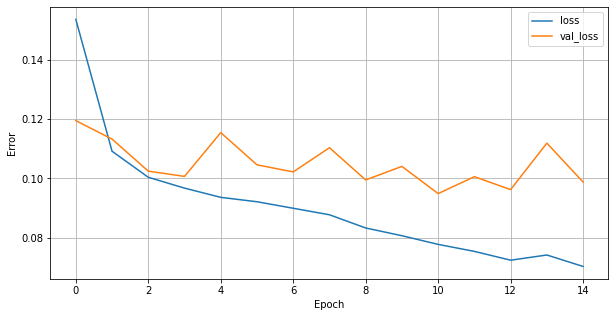

In [15]:

plt.rcParams['figure.figsize'] = [10, 5]
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)


In [16]:
score = model.evaluate(val_ds, verbose=0)
print("Test loss:", score)
#print("Test accuracy:", score[1])


Test loss: 0.09916932880878448


In [17]:
#print(train_ds[0])
#plt.imshow(images[x].numpy().astype("uint8"))
#plt.title(
#    "{:.4f} / {:.4f}".format(labels[x].numpy()[3], model.predict(images)[0][0]))
#plt.axis("off")


The last 32 images are validation images


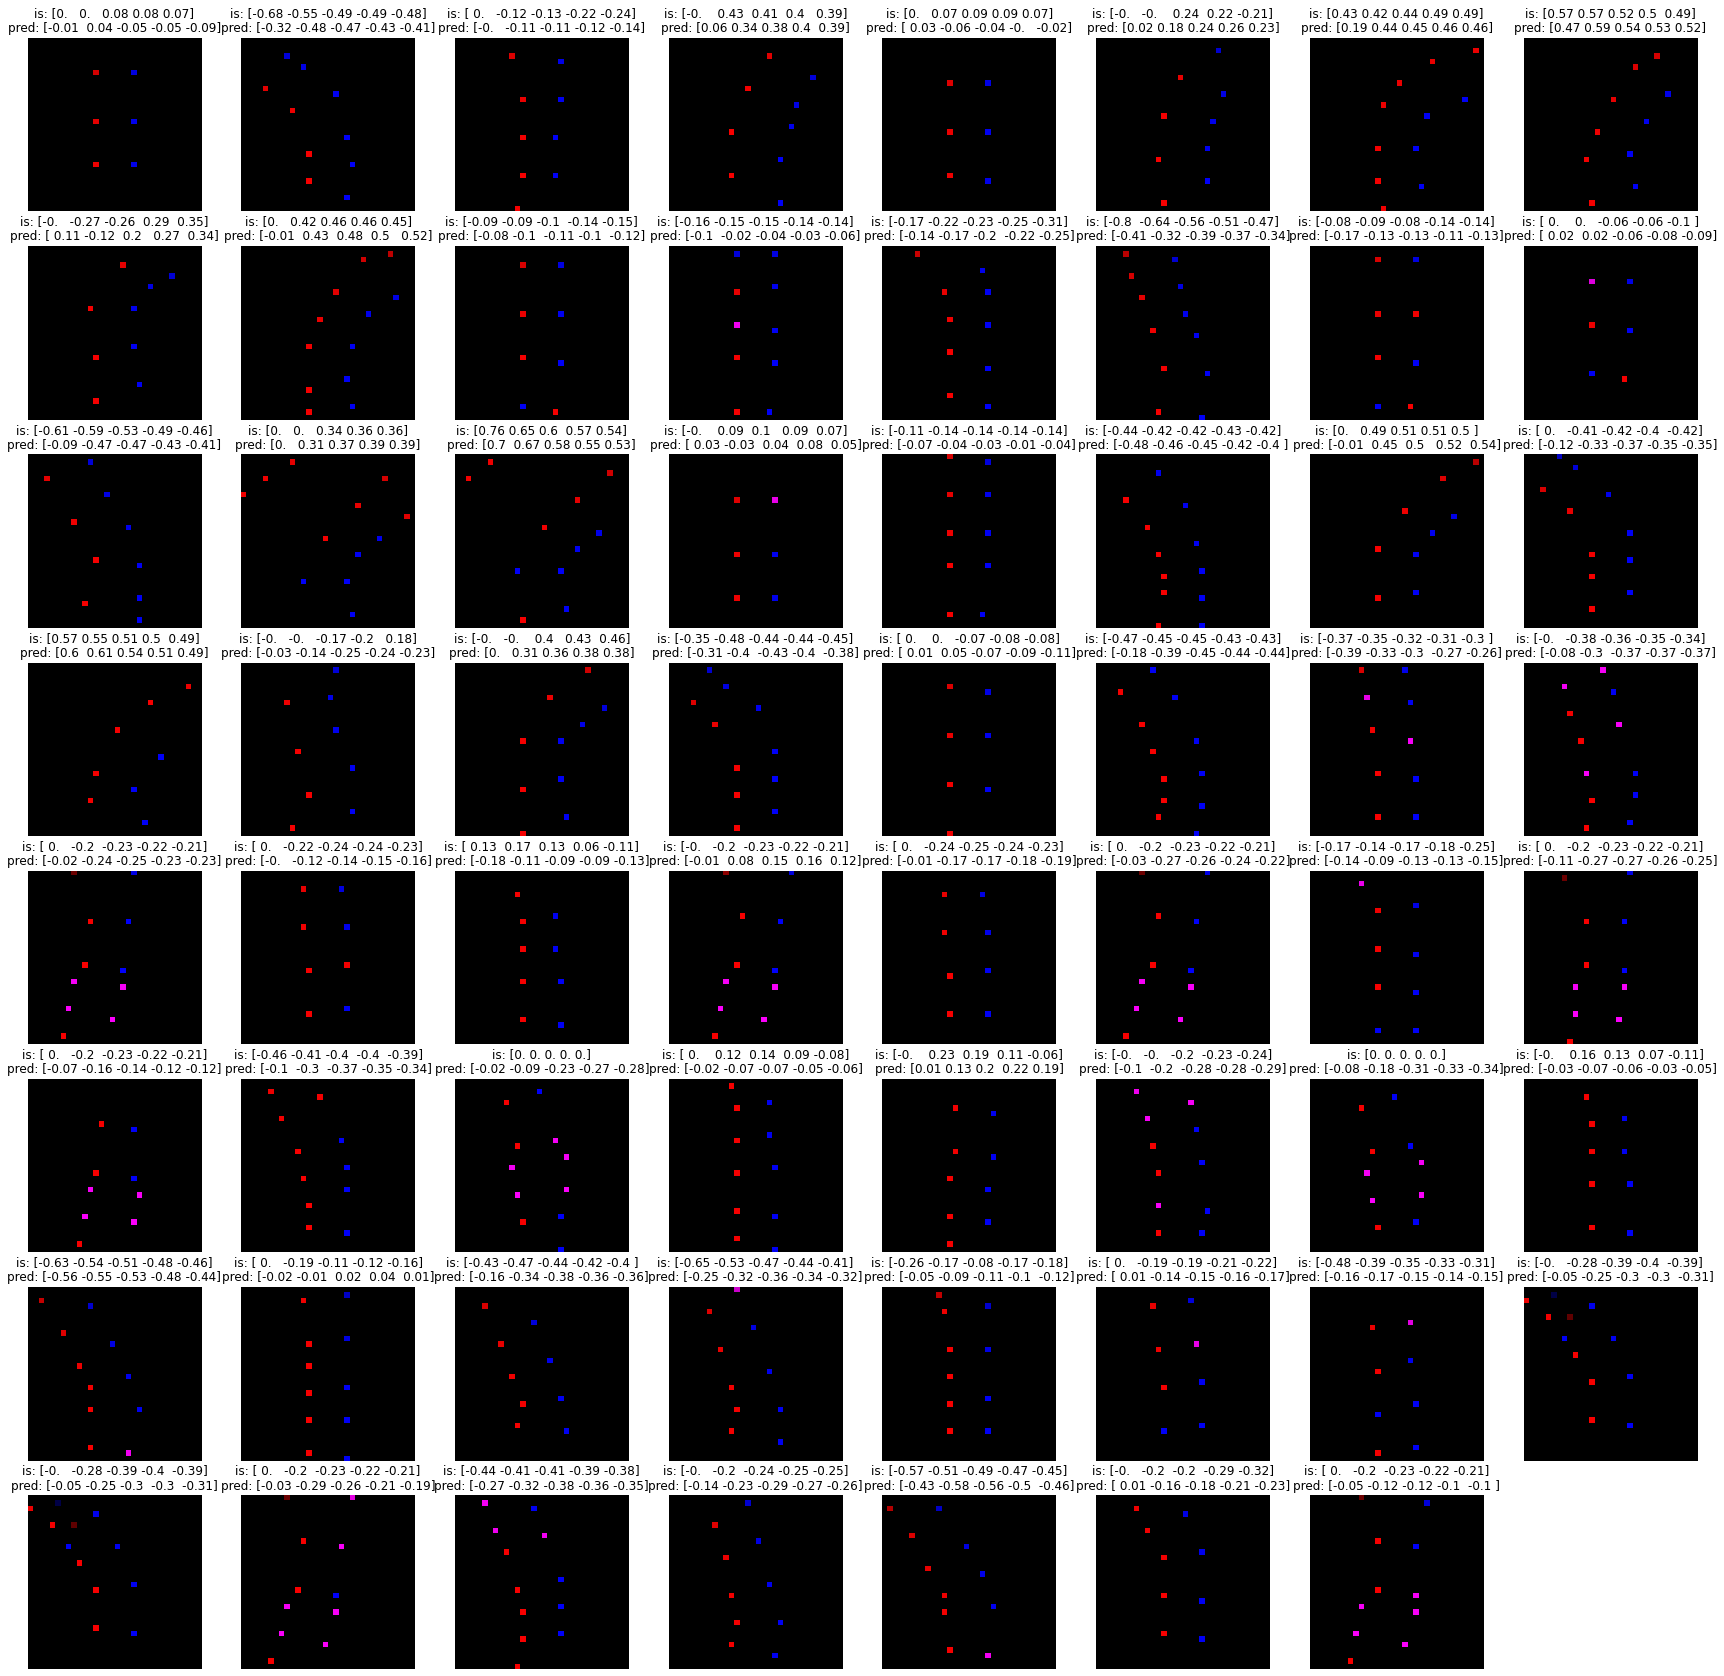

In [18]:
# plt.rcParams['figure.figsize'] = [15, 15]
# for i in range(49):
#     plt.subplot(7, 7, i+1)
#     plt.imshow(x_test[i].reshape(28, 28), cmap='gray', interpolation='none')
#     plt.axis('off')
#     plt.title("{}, is: {:.2f}".format(
#         y_test[i], model.predict(x_test[i:i+1])[0][0],2))

plt.rcParams['figure.figsize'] = [30, 30]
with np.printoptions(precision=2, suppress=True):
  for i, (images, labels) in enumerate(train_ds.shuffle(200).take(32)):
      if i == steps_per_epoch:
        print("First %d images are training images" % (steps_per_epoch * batch_size*0+32))
        break

      preds = model.predict(images)
      # print(preds.shape)
      for image, label, pred in zip(images, labels, preds):
        i=i+1
        ax = plt.subplot(8, 8, i)
        plt.imshow((image.numpy()*255).astype("uint8"))
        plt.title(
            "is: %s\npred: %s" %(label.numpy(), pred))
        plt.axis("off")

  print("The last %d images are validation images" %
        (len(val_ds) * batch_size*0+32))
  for i, (images, labels) in enumerate(val_ds.shuffle(200).take(32)):
      preds = model.predict(images)
      for image, label, pred in zip(images, labels, preds):
        ax = plt.subplot(8, 8, i+32)
        plt.imshow((image.numpy()*255).astype("uint8"))
        plt.title(
            "is: %s\npred: %s" %(label.numpy(), pred))
        plt.axis("off")
